<a href="https://colab.research.google.com/github/sooo19/A-study-of-the-data-generation-model-of-the-Folk-Painting-source-data/blob/main/02_28_FTiger_training_Resnet%2BTransformerDecoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Caption -> ResNet, TransformerDecoder


https://www.kaggle.com/dipanjandas96/image-caption-resnet-transformerdecoder-pytorch

1. Creating features for Images Using Resnet

2. Train Trnasformer Decoder Model which predicts next word given a sequence of tockens and Image Features from Step1

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import torchvision
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import pickle
import gc
import random

pd.set_option('display.max_colwidth', None)

In [ ]:
# read data
# "/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/archive/Images"
# "/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/archive/captions.txt",

df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/Image_Captioning/0226_Folk Dataset_ImageCaptioning/dataset_complete/caption2.txt', sep=',')
print(len(df))
display(df.head(3)) # 데이터가 제대로 읽어와졌는지 확인하기 위해, 상위 3개 caption 출력.
display(df.tail(3))


4140


,image,caption
0,TMP00001.jpg,Painting of Tiger Magpie and Pine Tree .
1,TMP00001.jpg,Painting of Tiger Magpie and Pine Tree .
2,TMP00001.jpg,Painting of Tiger Magpie and Pine Tree .


,image,caption
4137,DCM00042.jpg,Documentary Painting .
4138,DCM00042.jpg,Documentary Painting .
4139,DCM00042.jpg,Documentary Painting .


#데이터 전처리
Single Character(단일 문자), non alpha word 제거, 토큰과 ',' 추가.
모든 캡션의 최대 길이(max_seq_len)는 33으로 맞춰진다.


In [ ]:
def remove_single_char_word(word_list):
  lst=[]
  for word in word_list:
    if len(word)>1:
      lst.append(word)
  return lst

In [ ]:
# <start> < > < > ... < > <end> 형태로 캡션 저장 => 최대 길이: 3
df['cleaned_caption']=df['caption'].apply(lambda caption : ['<start>']+[word.lower() if word.isalpha() else '' for word in caption.split(" ")]+['<end>'])

# single character 제거
df['cleaned_caption']=df['cleaned_caption'].apply(lambda x:remove_single_char_word(x))

# seq_len에 길이 저장 => 3
df['seq_len']=df['cleaned_caption'].apply(lambda x:len(x))
max_seq_len=df['seq_len'].max()
print(max_seq_len)

9


In [ ]:
df.drop(['seq_len'], axis = 1, inplace=True)
df['cleaned_caption']=df['cleaned_caption'].apply(lambda caption: caption+['<pad>']*(max_seq_len-len(caption)))

# 상위 3개 데이터 예시 출력
display(df.head(3))

,image,caption,cleaned_caption
0,TMP00001.jpg,Painting of Tiger Magpie and Pine Tree .,"[<start>, painting, of, tiger, magpie, and, pine, tree, <end>]"
1,TMP00001.jpg,Painting of Tiger Magpie and Pine Tree .,"[<start>, painting, of, tiger, magpie, and, pine, tree, <end>]"
2,TMP00001.jpg,Painting of Tiger Magpie and Pine Tree .,"[<start>, painting, of, tiger, magpie, and, pine, tree, <end>]"


# Create Vocab and mapping of token to ID

In [ ]:
word_list=df['cleaned_caption'].apply(lambda x: " ".join(x)).str.cat(sep=' ').split(' ')  
#join: , cat(concat): 문자열 합치기. sep=' '에 의해 한 칸씩 뛰고 저장이 된다.
word_dict=Counter(word_list)
word_dict=sorted(word_dict, key=word_dict.get, reverse=True)

print(len(word_dict))
print(word_dict[:20])

29
['<pad>', '<start>', '<end>', 'painting', 'of', 'and', 'flowers', 'birds', 'genre', 'tiger', 'magpie', 'pine', 'tree', 'peony', 'ten', 'symbols', 'longevity', 'fish', 'documentary', 'divine']


In [ ]:
vocab_size=len(word_dict)
print(vocab_size)

index_to_word = {index: word for index, word in enumerate(word_dict)} #enumerate: 반복문에서 index값(몇번째 요소인지)을 출력
word_to_index = {word: index for index, word in enumerate(word_dict)}
print(len(index_to_word), len(word_to_index))

29
29 29


# Convert sequence of tokens to IDs

text_seq를 부여함. 단어별로 ID를 부여함.

In [ ]:
df['text_seq']=df['cleaned_caption'].apply(lambda caption: [word_to_index[word] for word in caption])
display(df.head(3))

,image,caption,cleaned_caption,text_seq
0,TMP00001.jpg,Painting of Tiger Magpie and Pine Tree .,"[<start>, painting, of, tiger, magpie, and, pine, tree, <end>]","[1, 3, 4, 9, 10, 5, 11, 12, 2]"
1,TMP00001.jpg,Painting of Tiger Magpie and Pine Tree .,"[<start>, painting, of, tiger, magpie, and, pine, tree, <end>]","[1, 3, 4, 9, 10, 5, 11, 12, 2]"
2,TMP00001.jpg,Painting of Tiger Magpie and Pine Tree .,"[<start>, painting, of, tiger, magpie, and, pine, tree, <end>]","[1, 3, 4, 9, 10, 5, 11, 12, 2]"


# Split in Train and validation data. 
(Train과 validation data 나누기) 
한 데이터가 동시에 training, validation data가 될 수 없음.

In [ ]:
df=df.sort_values(by='image')
train=df.iloc[:int(1.0*len(df))]  # train과 validation의 비율은 10:1
valid=df.iloc[int(0.0*len(df)):]

print(len(train), train['image'].nunique()) #nunique() : 데이터에 고유값들의 수를 출력, 즉 중복되는 않은 순 단어의 개수 세기
print(len(valid), valid['image'].nunique())

4140 828
4140 828


# Extract features from Images Using Resnet
Restnet 구조를 통해 feature 추출

In [ ]:
train_samples=len(train)
print(train_samples)  # train 길이 출력

unq_train_imgs=train[['image']].drop_duplicates() #중복되는 이미지 제거
unq_valid_imgs = valid[['image']].drop_duplicates()
print(len(unq_train_imgs), len(unq_valid_imgs))

4140
828 828


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) #Cuda 사용

cuda


In [ ]:
class extractImageFeatureResNetDataSet(): # Resnet 구조를 이용해 이미지의 feature 값들을 추출
  def __init__(self, data):
    self.data=data
    self.scaler=transforms.Resize([224, 224]) # 이미지 크기 재정의
    self.normalize=transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    self.to_tensor=transforms.ToTensor()

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image_name=self.data.iloc[idx]['image']
    img_loc="/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/Image_Captioning/0226_Folk Dataset_ImageCaptioning/dataset_complete/images/" + str(image_name)
    img=Image.open(img_loc)
    t_img=self.normalize(self.to_tensor(self.scaler(img)))
    return image_name, t_img

In [ ]:
from torchvision import transforms

In [ ]:
train_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_train_imgs)  # train 이미지들의 feature를 추출해 저장
train_ImageDataloader_ResNet = DataLoader(train_ImageDataset_ResNet, batch_size=1, shuffle=False) # true로 수정, batch size도 클수록 효과가 좋아짐 (2^n 단위로 키우기)

valid_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_valid_imgs)  # validation 이미지들의 feature를 추출해 저장
valid_ImageDataloader_ResNet = DataLoader(valid_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [ ]:
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()
list(resnet18._modules)

['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [ ]:
resNet18Layer4 = resnet18._modules.get('layer4').to(device)

In [ ]:
def get_vector(t_img):
  t_img = Variable(t_img)
  my_embedding = torch.zeros(1, 512, 7, 7)  # torch.zeros : 0으로 채워진 텐서 생성
  def copy_data(m, i, o):
    my_embedding.copy_(o.data)

  h = resNet18Layer4.register_forward_hook(copy_data)
  resnet18(t_img)

  h.remove()
  return my_embedding

In [ ]:
#print("/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/archive/Images/1000268201_693b08cb0e.jpg")

In [ ]:
'''
import matplotlib.pyplot as plt
import matplotlib.image as img

image = img.imread('/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/Image_Captioning/0226_Folk Dataset_ImageCaptioning/dataset_complete/images/DCM00003-1.jpg')
plt.imshow(image)
plt.show()
'''

"\nimport matplotlib.pyplot as plt\nimport matplotlib.image as img\n\nimage = img.imread('/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/Image_Captioning/0226_Folk Dataset_ImageCaptioning/dataset_complete/images/DCM00003-1.jpg')\nplt.imshow(image)\nplt.show()\n"

In [ ]:
extract_imgFtr_ResNet_train = {}  # train 이미지들의 feature 추출
for image_name, t_img in tqdm(train_ImageDataloader_ResNet):   # tqdm: 진행률 프로그래스바
  t_img = t_img.to(device)
  embdg = get_vector(t_img)

  extract_imgFtr_ResNet_train[image_name[0]] = embdg

  0%|          | 0/828 [00:00<?, ?it/s]

In [ ]:
a_file = open("./EncodedImageTrainResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_train, a_file)
a_file.close()

In [ ]:
#t_image = Image.open(image_name).convert('RGB')

In [ ]:
extract_imgFtr_ResNet_valid = {}
for image_name, t_img in tqdm(valid_ImageDataloader_ResNet):
  t_img = t_img.to(device)
  embdg = get_vector(t_img)
  extract_imgFtr_ResNet_valid[image_name[0]] = embdg

  0%|          | 0/828 [00:00<?, ?it/s]

In [ ]:
a_file=open("./EncodedImageValidResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_valid, a_file)
a_file.close()

#Create DataLoader which will be used to load data into Transformer Model
Transformer 모델에 데이터를 load하는데 사용할 dataloader을 생성

(FlickerDataSetResnet will return caption sequence, 1 timestep left shifted caption sequence which model will predict and Stored Image features from ResNet.)

In [ ]:
global image_tensor_view

class FlickerDataSetResnet():
  def __init__(self, data, pkl_file):
    self.data=data
    self.encodedImgs = pd.read_pickle(pkl_file)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    caption_seq = self.data.iloc[idx]['text_seq']
    target_seq = caption_seq[1:]+[0]

    image_name = self.data.iloc[idx]['image']
    image_tensor = self.encodedImgs[image_name]
    image_tensor = image_tensor.permute(0,2,3,1)  # tensor의 모양을 변환. permute는 모든 차원을 교환할 수 있음.
    image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))
    return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [ ]:
train_dataset_resnet = FlickerDataSetResnet(train, 'EncodedImageTrainResNet.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size = 32, shuffle=True)

In [ ]:
valid_dataset_resnet = FlickerDataSetResnet(valid, 'EncodedImageValidResNet.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size = 32, shuffle = True)

#Create Transformer Decoder Model
This model will take caption sequence and the extracted resnet image features as input and output 1 timestep shifted caption sequence.

In the Transformer decoder, lookAhead and padding mask has also been applied

In [ ]:
# Position Embedding

class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]
        
        x = x + self.pe
        return self.dropout(x)

In [ ]:
# Image Captioning Model
# Transformer Decoder

class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)
        

        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)
        
        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)
        

        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)
        

        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)
        
        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask

#Train the Model

The cross entropy loss has been masked at time steps where input token is <'pad'>.

In [ ]:
#EPOCH = 300
#EPOCH = 150
EPOCH = 10

In [ ]:
ictModel = ImageCaptionModel(16, 4, vocab_size, 512).to(device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr = 0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2, verbose=True)
criterion=torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss=np.float('Inf')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [ ]:
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_dataloader_resnet:
        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        loss = criterion(output,target_seq)

        loss_masked = torch.mul(loss, padding_mask)

        final_batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

        final_batch_loss.backward()
        optimizer.step()
        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask)

 
    total_epoch_train_loss = total_epoch_train_loss/total_train_words
  

    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_dataloader_resnet:

            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output,target_seq)

            loss_masked = torch.mul(loss, padding_mask)

            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask)

    total_epoch_valid_loss = total_epoch_valid_loss/total_valid_words
  
    print("Epoch -> ", epoch," Training Loss -> ", total_epoch_train_loss.item(), "Eval Loss -> ", total_epoch_valid_loss.item() )
  
    if min_val_loss > total_epoch_valid_loss:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel, './BestModel')
        min_val_loss = total_epoch_valid_loss
  

    scheduler.step(total_epoch_valid_loss.item())

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch ->  0  Training Loss ->  1.3640800714492798 Eval Loss ->  0.40656590461730957
Writing Model at epoch  0
Epoch ->  1  Training Loss ->  0.3378412127494812 Eval Loss ->  0.21449680626392365
Writing Model at epoch  1
Epoch ->  2  Training Loss ->  0.21790587902069092 Eval Loss ->  0.1548880636692047
Writing Model at epoch  2
Epoch ->  3  Training Loss ->  0.16731779277324677 Eval Loss ->  0.12350770831108093
Writing Model at epoch  3
Epoch ->  4  Training Loss ->  0.13363610208034515 Eval Loss ->  0.0902610719203949
Writing Model at epoch  4
Epoch ->  5  Training Loss ->  0.10608363151550293 Eval Loss ->  0.06910063326358795
Writing Model at epoch  5
Epoch ->  6  Training Loss ->  0.08468083292245865 Eval Loss ->  0.05219709873199463
Writing Model at epoch  6
Epoch ->  7  Training Loss ->  0.06607213616371155 Eval Loss ->  0.03790664300322533
Writing Model at epoch  7
Epoch ->  8  Training Loss ->  0.053173646330833435 Eval Loss ->  0.03271808102726936
Writing Model at epoch  8
Epoc

#Generate Captions

In [ ]:
model = torch.load('./BestModel')
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
max_seq_len = 9  # 캡션의 max length
print(start_token, end_token, pad_token)

1 2 0


In [ ]:
valid_img_embed = pd.read_pickle('EncodedImageValidResNet.pkl')

In [ ]:
def generate_caption(K, img_nm): 
    img_loc = '/content/gdrive/MyDrive/Colab Notebooks/Folk Painting Source Data/Image_Captioning/0226_Folk Dataset_ImageCaptioning/dataset_complete/images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    model.eval() 
    valid_img_df = valid[valid['image']==img_nm]
    print("Actual Caption : ")
    print(valid_img_df['caption'].tolist())
    img_embed = valid_img_embed[img_nm].to(device)


    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))


    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index


            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    print("\n")
    print("Predicted caption : ")
    print(" ".join(predicted_sentence+['.']))

#Test print (Tiger folk paintings)
호랑이 민화 10장(t1.jpg~t10.jpg)에 대한 예측 캡션 생성

Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption 

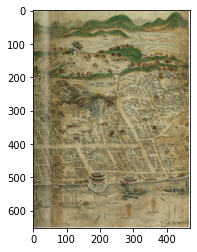

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[1]['image'])
  print("\n")

Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption 

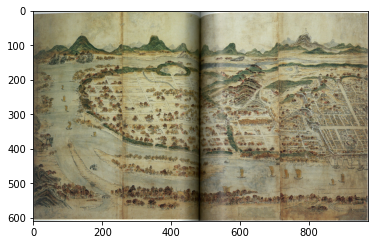

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[2]['image'])
  print("\n")

Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption 

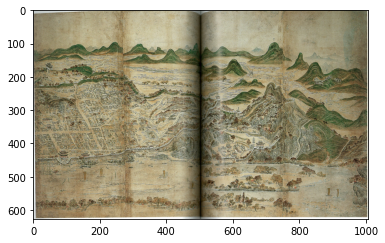

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[3]['image'])
  print("\n")

Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption 

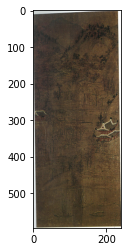

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[5]['image'])
  print("\n")

Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption 

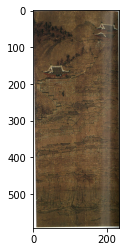

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[6]['image'])
  print("\n")

Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption 

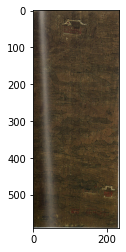

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[7]['image'])
  print("\n")

Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption 

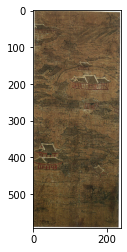

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[8]['image'])
  print("\n")

Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption 

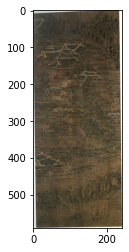

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[9]['image'])
  print("\n")

Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption 

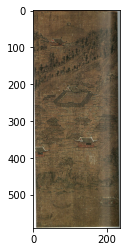

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[10]['image'])
  print("\n")

Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption 

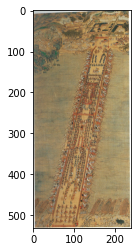

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[15]['image'])
  print("\n")

Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption 

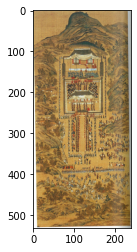

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[20]['image'])
  print("\n")

Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption 

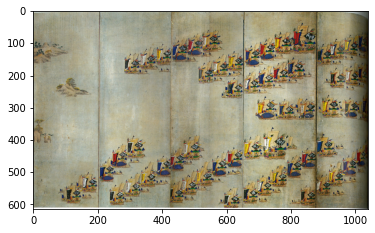

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[25]['image'])
  print("\n")

Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption : 
['Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .', 'Documentary Painting .']


Predicted caption : 
documentary painting .


Actual Caption 

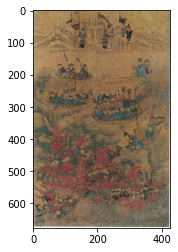

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[30]['image'])
  print("\n")

Actual Caption : 
['Painting of Dragon .', 'Painting of Dragon .', 'Painting of Dragon .', 'Painting of Dragon .', 'Painting of Dragon .']


Predicted caption : 
painting of dragon .


Actual Caption : 
['Painting of Dragon .', 'Painting of Dragon .', 'Painting of Dragon .', 'Painting of Dragon .', 'Painting of Dragon .']


Predicted caption : 
painting of dragon .


Actual Caption : 
['Painting of Dragon .', 'Painting of Dragon .', 'Painting of Dragon .', 'Painting of Dragon .', 'Painting of Dragon .']


Predicted caption : 
painting of dragon .


Actual Caption : 
['Painting of Dragon .', 'Painting of Dragon .', 'Painting of Dragon .', 'Painting of Dragon .', 'Painting of Dragon .']


Predicted caption : 
painting of dragon .


Actual Caption : 
['Painting of Dragon .', 'Painting of Dragon .', 'Painting of Dragon .', 'Painting of Dragon .', 'Painting of Dragon .']


Predicted caption : 
painting of dragon .


Actual Caption : 
['Painting of Dragon .', 'Painting of Dragon .', 'Paintin

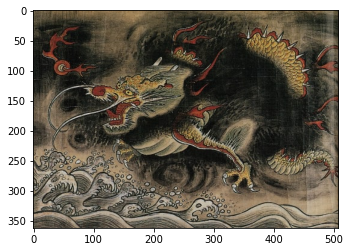

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[50]['image'])
  print("\n")

Actual Caption : 
['Painting of Divine Animals .', 'Painting of Divine Animals .', 'Painting of Divine Animals .', 'Painting of Divine Animals .', 'Painting of Divine Animals .']


Predicted caption : 
painting of divine animals .


Actual Caption : 
['Painting of Divine Animals .', 'Painting of Divine Animals .', 'Painting of Divine Animals .', 'Painting of Divine Animals .', 'Painting of Divine Animals .']


Predicted caption : 
painting of divine animals .


Actual Caption : 
['Painting of Divine Animals .', 'Painting of Divine Animals .', 'Painting of Divine Animals .', 'Painting of Divine Animals .', 'Painting of Divine Animals .']


Predicted caption : 
painting of divine animals .


Actual Caption : 
['Painting of Divine Animals .', 'Painting of Divine Animals .', 'Painting of Divine Animals .', 'Painting of Divine Animals .', 'Painting of Divine Animals .']


Predicted caption : 
painting of divine animals .


Actual Caption : 
['Painting of Divine Animals .', 'Painting of Divi

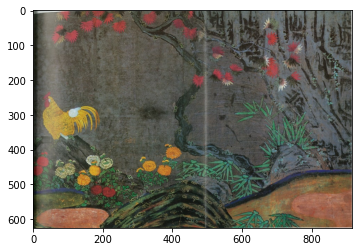

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[100]['image'])
  print("\n")

Actual Caption : 
['Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .']


Predicted caption : 
painting of flowers and birds .


Actual Caption : 
['Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .']


Predicted caption : 
painting of flowers and birds .


Actual Caption : 
['Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .']


Predicted caption : 
painting of flowers and birds .


Actual Caption : 
['Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .']


Predicted caption : 
painting of flowers and birds 

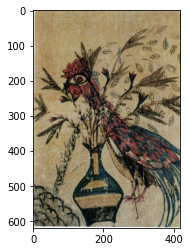

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[150]['image'])
  print("\n")

Actual Caption : 
['Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .']


Predicted caption : 
painting of flowers and birds .


Actual Caption : 
['Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .']


Predicted caption : 
painting of flowers and birds .


Actual Caption : 
['Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .']


Predicted caption : 
painting of flowers and birds .


Actual Caption : 
['Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .']


Predicted caption : 
painting of flowers and birds 

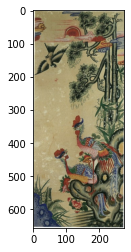

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[200]['image'])
  print("\n")

Actual Caption : 
['Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .']


Predicted caption : 
painting of flowers and birds .


Actual Caption : 
['Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .']


Predicted caption : 
painting of flowers and birds .


Actual Caption : 
['Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .']


Predicted caption : 
painting of flowers and birds .


Actual Caption : 
['Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .']


Predicted caption : 
painting of flowers and birds 

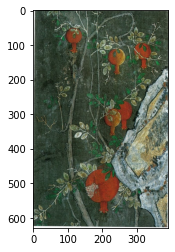

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[250]['image'])
  print("\n")

Actual Caption : 
['Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .']


Predicted caption : 
painting of flowers and birds .


Actual Caption : 
['Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .']


Predicted caption : 
painting of flowers and birds .


Actual Caption : 
['Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .']


Predicted caption : 
painting of flowers and birds .


Actual Caption : 
['Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .', 'Painting of Flowers and Birds .']


Predicted caption : 
painting of flowers and birds 

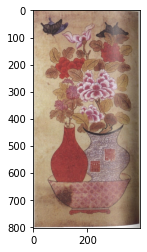

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[300]['image'])
  print("\n")

Actual Caption : 
['Painting of Flowers and Insects .', 'Painting of Flowers and Insects .', 'Painting of Flowers and Insects .', 'Painting of Flowers and Insects .', 'Painting of Flowers and Insects .']


Predicted caption : 
painting of flowers and insects .


Actual Caption : 
['Painting of Flowers and Insects .', 'Painting of Flowers and Insects .', 'Painting of Flowers and Insects .', 'Painting of Flowers and Insects .', 'Painting of Flowers and Insects .']


Predicted caption : 
painting of flowers and insects .


Actual Caption : 
['Painting of Flowers and Insects .', 'Painting of Flowers and Insects .', 'Painting of Flowers and Insects .', 'Painting of Flowers and Insects .', 'Painting of Flowers and Insects .']


Predicted caption : 
painting of flowers and insects .


Actual Caption : 
['Painting of Flowers and Insects .', 'Painting of Flowers and Insects .', 'Painting of Flowers and Insects .', 'Painting of Flowers and Insects .', 'Painting of Flowers and Insects .']


Predi

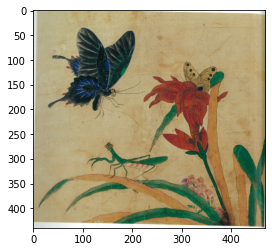

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[350]['image'])
  print("\n")

Actual Caption : 
['Painting of Fruits and Vegetables .', 'Painting of Fruits and Vegetables .', 'Painting of Fruits and Vegetables .', 'Painting of Fruits and Vegetables .', 'Painting of Fruits and Vegetables .']


Predicted caption : 
painting of fruits and vegetables .


Actual Caption : 
['Painting of Fruits and Vegetables .', 'Painting of Fruits and Vegetables .', 'Painting of Fruits and Vegetables .', 'Painting of Fruits and Vegetables .', 'Painting of Fruits and Vegetables .']


Predicted caption : 
painting of fruits and vegetables .


Actual Caption : 
['Painting of Fruits and Vegetables .', 'Painting of Fruits and Vegetables .', 'Painting of Fruits and Vegetables .', 'Painting of Fruits and Vegetables .', 'Painting of Fruits and Vegetables .']


Predicted caption : 
painting of fruits and vegetables .


Actual Caption : 
['Painting of Fruits and Vegetables .', 'Painting of Fruits and Vegetables .', 'Painting of Fruits and Vegetables .', 'Painting of Fruits and Vegetables .', 

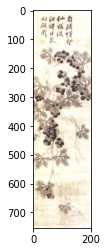

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[400]['image'])
  print("\n")

Actual Caption : 
['Painting of Fish .', 'Painting of Fish .', 'Painting of Fish .', 'Painting of Fish .', 'Painting of Fish .']


Predicted caption : 
painting of fish .


Actual Caption : 
['Painting of Fish .', 'Painting of Fish .', 'Painting of Fish .', 'Painting of Fish .', 'Painting of Fish .']


Predicted caption : 
painting of fish .


Actual Caption : 
['Painting of Fish .', 'Painting of Fish .', 'Painting of Fish .', 'Painting of Fish .', 'Painting of Fish .']


Predicted caption : 
painting of fish .


Actual Caption : 
['Painting of Fish .', 'Painting of Fish .', 'Painting of Fish .', 'Painting of Fish .', 'Painting of Fish .']


Predicted caption : 
painting of fish .


Actual Caption : 
['Painting of Fish .', 'Painting of Fish .', 'Painting of Fish .', 'Painting of Fish .', 'Painting of Fish .']


Predicted caption : 
painting of fish .


Actual Caption : 
['Painting of Fish .', 'Painting of Fish .', 'Painting of Fish .', 'Painting of Fish .', 'Painting of Fish .']


Pred

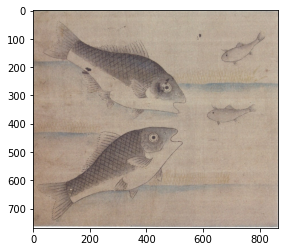

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[450]['image'])
  print("\n")

Actual Caption : 
['Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .']


Predicted caption : 
genre painting .


Actual Caption : 
['Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .']


Predicted caption : 
genre painting .


Actual Caption : 
['Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .']


Predicted caption : 
genre painting .


Actual Caption : 
['Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .']


Predicted caption : 
genre painting .


Actual Caption : 
['Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .']


Predicted caption : 
genre painting .


Actual Caption : 
['Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .']


Predicted caption : 
genre painting .


Actual Caption : 
['Genre Painting

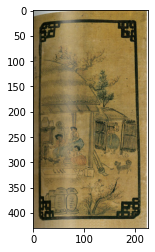

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[500]['image'])
  print("\n")

Actual Caption : 
['Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .']


Predicted caption : 
genre painting .


Actual Caption : 
['Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .']


Predicted caption : 
genre painting .


Actual Caption : 
['Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .']


Predicted caption : 
genre painting .


Actual Caption : 
['Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .']


Predicted caption : 
genre painting .


Actual Caption : 
['Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .']


Predicted caption : 
genre painting .


Actual Caption : 
['Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .', 'Genre Painting .']


Predicted caption : 
genre painting .


Actual Caption : 
['Genre Painting

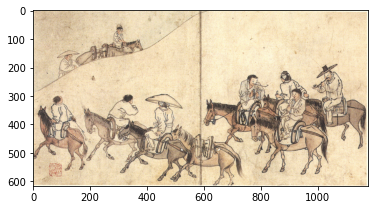

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[550]['image'])
  print("\n")

Actual Caption : 
['Painting of Lotus .', 'Painting of Lotus .', 'Painting of Lotus .', 'Painting of Lotus .', 'Painting of Lotus .']


Predicted caption : 
painting of lotus .


Actual Caption : 
['Painting of Lotus .', 'Painting of Lotus .', 'Painting of Lotus .', 'Painting of Lotus .', 'Painting of Lotus .']


Predicted caption : 
painting of lotus .


Actual Caption : 
['Painting of Lotus .', 'Painting of Lotus .', 'Painting of Lotus .', 'Painting of Lotus .', 'Painting of Lotus .']


Predicted caption : 
painting of lotus .


Actual Caption : 
['Painting of Lotus .', 'Painting of Lotus .', 'Painting of Lotus .', 'Painting of Lotus .', 'Painting of Lotus .']


Predicted caption : 
painting of lotus .


Actual Caption : 
['Painting of Lotus .', 'Painting of Lotus .', 'Painting of Lotus .', 'Painting of Lotus .', 'Painting of Lotus .']


Predicted caption : 
painting of lotus .


Actual Caption : 
['Painting of Lotus .', 'Painting of Lotus .', 'Painting of Lotus .', 'Painting of Lotu

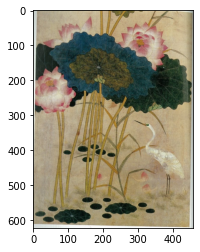

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[600]['image'])
  print("\n")

Actual Caption : 
['Painting of Peony .', 'Painting of Peony .', 'Painting of Peony .', 'Painting of Peony .', 'Painting of Peony .']


Predicted caption : 
painting of peony .


Actual Caption : 
['Painting of Peony .', 'Painting of Peony .', 'Painting of Peony .', 'Painting of Peony .', 'Painting of Peony .']


Predicted caption : 
painting of peony .


Actual Caption : 
['Painting of Peony .', 'Painting of Peony .', 'Painting of Peony .', 'Painting of Peony .', 'Painting of Peony .']


Predicted caption : 
painting of peony .


Actual Caption : 
['Painting of Peony .', 'Painting of Peony .', 'Painting of Peony .', 'Painting of Peony .', 'Painting of Peony .']


Predicted caption : 
painting of peony .


Actual Caption : 
['Painting of Peony .', 'Painting of Peony .', 'Painting of Peony .', 'Painting of Peony .', 'Painting of Peony .']


Predicted caption : 
painting of peony .


Actual Caption : 
['Painting of Peony .', 'Painting of Peony .', 'Painting of Peony .', 'Painting of Peon

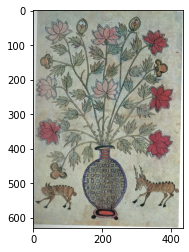

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[650]['image'])
  print("\n")

Actual Caption : 
['Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .']


Predicted caption : 
painting of tiger magpie and pine tree .


Actual Caption : 
['Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .']


Predicted caption : 
painting of tiger magpie and pine tree .


Actual Caption : 
['Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .']


Predicted caption : 
painting of tiger magpie and pine tree .


Actual Caption : 
['Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Mag

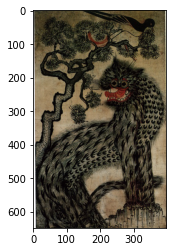

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[700]['image'])
  print("\n")

Actual Caption : 
['Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .']


Predicted caption : 
painting of tiger magpie and pine tree .


Actual Caption : 
['Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .']


Predicted caption : 
painting of tiger magpie and pine tree .


Actual Caption : 
['Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Magpie and Pine Tree .']


Predicted caption : 
painting of tiger magpie and pine tree .


Actual Caption : 
['Painting of Tiger Magpie and Pine Tree .', 'Painting of Tiger Mag

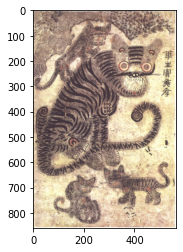

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[750]['image'])
  print("\n")

Actual Caption : 
['Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .']


Predicted caption : 
painting of ten symbols of longevity .


Actual Caption : 
['Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .']


Predicted caption : 
painting of ten symbols of longevity .


Actual Caption : 
['Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .']


Predicted caption : 
painting of ten symbols of longevity .


Actual Caption : 
['Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .', 'Painting of Ten S

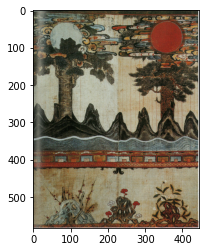

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[800]['image'])
  print("\n")

Actual Caption : 
['Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .']


Predicted caption : 
painting of flowers and birds .


Actual Caption : 
['Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .']


Predicted caption : 
painting of flowers and birds .


Actual Caption : 
['Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .']


Predicted caption : 
painting of flowers and birds .


Actual Caption : 
['Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .', 'Painting of Ten Symbols of Longevity .

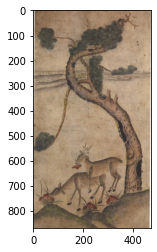

In [ ]:
for i in range(1, 10):
  generate_caption(1, unq_train_imgs.iloc[-1]['image'])
  print("\n")